# Supervised CARE Training

Here we use CARE training using noisy images as input and averaged noisy images as target.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np

from ppn2v.unet import UNet
from ppn2v.pn2v import utils

from ppn2v.pn2v import training
from tifffile import imread
# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Download data
Download the data from  https://zenodo.org/record/5156937/files/Mouse%20actin.zip?download=1. Here we show the pipeline for Mouse actin dataset. Save the dataset at an appropriate location. For us, the path is data folder which exists at `../../../`. For Mouse actin, the data to be denoised is named ```sample_attempt2.tif```. 

In [ ]:
# Download data
import os
import urllib
import zipfile

if not os.path.isdir('../../../data'):
    os.mkdir('../../../data')

if not os.path.isdir('../../../data/Mouse actin/'):
    os.mkdir('../../../data/Mouse actin/')

zipPath="../../../data/Mouse actin/Mouse_actin.zip"
if not os.path.exists(zipPath):  
    data = urllib.request.urlretrieve(' https://zenodo.org/record/5156937/files/Mouse%20actin.zip?download=1', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("../../../data/Mouse actin/")


### Load Data
####  Ensure ```filename = sample_attempt2.tif``` and specify the ```dataName```  

In [21]:
path='../../../data/Mouse actin/Mouse actin/'
fileName='sample_attempt2.tif'
dataName='mouseactin' # This will be used to name the care model

#### Noisy Data (Input to network)

In [22]:
data=imread(path+fileName)
nameModel=dataName+'_care'

#### Ground truth Data (Target of Network)

In [23]:
dataGT = np.mean(data, axis=0)[np.newaxis,...,np.newaxis]

In [24]:
data=data[...,np.newaxis]
dataGT = np.repeat(dataGT, 100, axis=0)
print("Shape of Raw Noisy Image is ", data.shape, "; Shape of Target Image is ", dataGT.shape)
data = np.concatenate((data,dataGT),axis=-1)
# Add the target image as a second channel to `data`
print("Shape of `data` is ", data.shape)

Shape of Raw Noisy Image is  (100, 1024, 1024, 1) ; Shape of Target Image is  (100, 1024, 1024, 1)
Shape of `data` is  (100, 1024, 1024, 2)


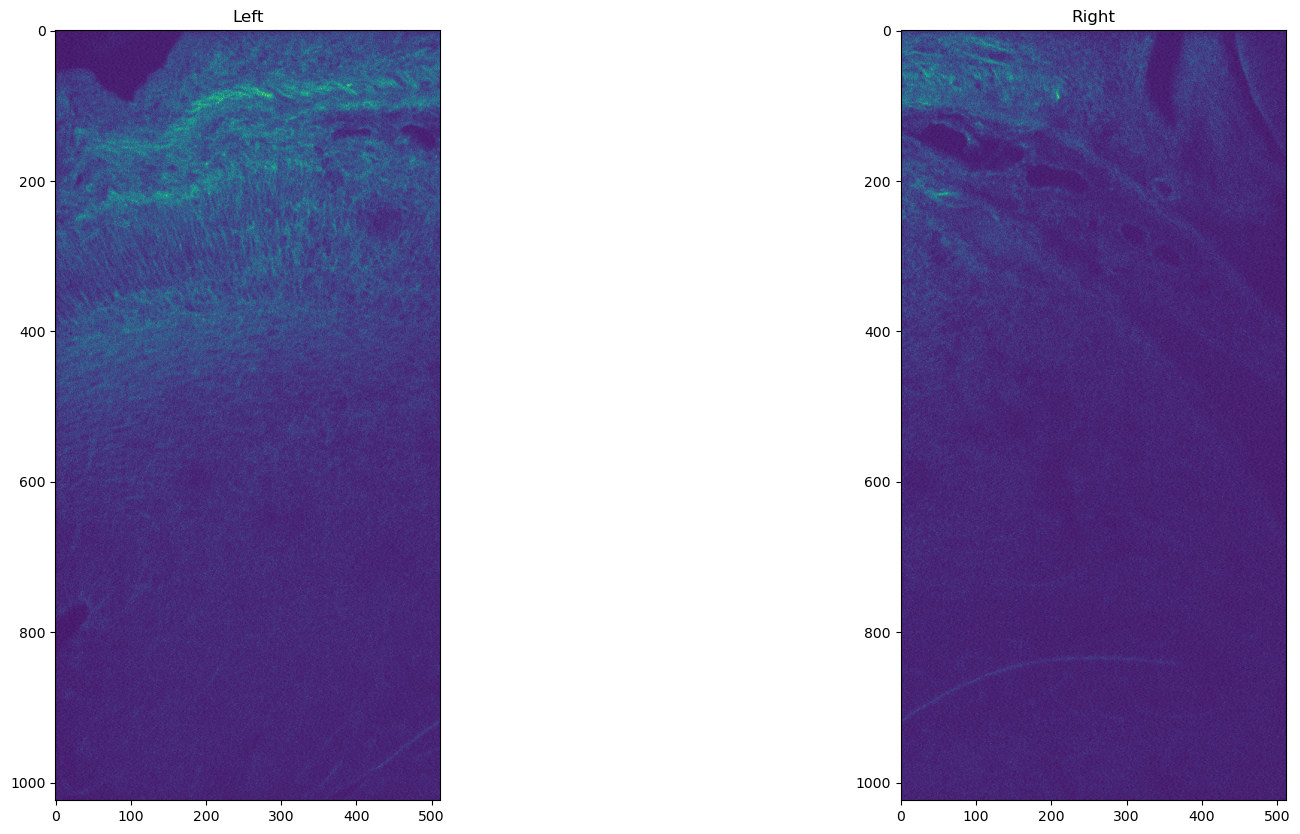

In [25]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(data[0,:,:512,0])
plt.title('Left')

plt.subplot(1,2,2)
plt.imshow(data[0,:,512:,0])
plt.title('Right')

plt.show()

# We now crop away the left portion of the data since this portion will be used later for testing
data = data[:, :, 512:, :]

### Create the Network and Train it
This can take a while. Ensure that `supervised` = `True`.

In [26]:
# The N2V network requires only a single output unit per pixel
net = UNet(1, depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()

# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix=nameModel, directory=path, noiseModel=None,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=5, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3, supervised=True)

Epoch 0 finished      
avg. loss: 0.4400211781263351+-(2SEM)0.3867675514102668      
Epoch 1 finished      
avg. loss: 0.1553654121235013+-(2SEM)0.06112654492721853      
Epoch 2 finished      
avg. loss: 0.18252117102965712+-(2SEM)0.12387292865241989      
Epoch 3 finished      
avg. loss: 0.0668046260252595+-(2SEM)0.030225149389861188      
Epoch 4 finished      
avg. loss: 0.05233206460252404+-(2SEM)0.019687342645462555      
Epoch 5 finished      
avg. loss: 0.04483693367801607+-(2SEM)0.01794070541176988      
Epoch 6 finished      
avg. loss: 0.052120353141799566+-(2SEM)0.022330631157347795      
Epoch 7 finished      
avg. loss: 0.037138105789199474+-(2SEM)0.014194684442856025      
Epoch 8 finished      
avg. loss: 0.04976453622803092+-(2SEM)0.026051659520426325      
Epoch 9 finished      
avg. loss: 0.029340157611295582+-(2SEM)0.018426936135931098      
Epoch 10 finished      
avg. loss: 0.036791736353188755+-(2SEM)0.015822448051646638      
Epoch 11 finished      
avg. loss: 

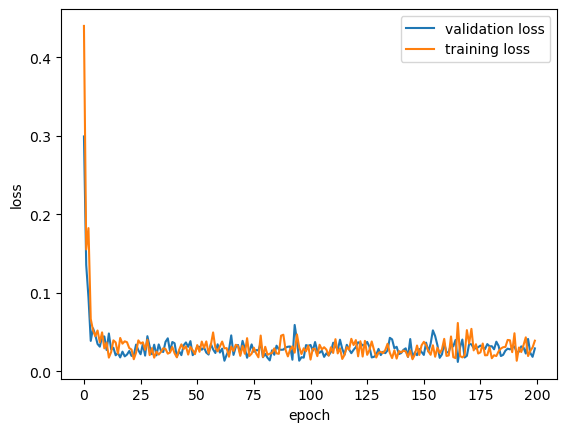

In [27]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()